In [1]:
import pandas as pd
import json

# Load training CSV
train_df1 = pd.read_csv("output/sample_training_1.csv")
train_df2 = pd.read_csv("output/sample_training_2.csv")
train_df = pd.concat([train_df1, train_df2], ignore_index=True)

# Load multi-label classification JSON (training_1 and training_2)
with open("data/training/subtask_2a/training_1.json", "r") as f1:
    train_labels_1 = json.load(f1)

with open("data/training/subtask_2a/training_2.json", "r") as f2:
    train_labels_2 = json.load(f2)

# Combine both JSON dictionaries
combined_train_labels = {**train_labels_1, **train_labels_2}

# Convert combined JSON to DataFrame
train_labels_df = pd.DataFrame.from_dict(combined_train_labels, orient="index").reset_index()
train_labels_df.rename(columns={"index": "note_id"}, inplace=True)

# Convert `note_id` to int for merging
train_labels_df["note_id"] = train_labels_df["note_id"].astype(int)
train_df["note_id"] = train_df["note_id"].astype(int)

# Merge training data with combined labels
train_df = train_df.merge(train_labels_df, on="note_id", how="left")

# Load validation data (CSV)
val_df = pd.read_csv("output/sample_validation.csv")

# Load validation labels (JSON)
with open("data/validation/subtask_2a/validation.json", "r") as f:
    val_labels = json.load(f)

# Convert JSON to DataFrame
val_labels_df = pd.DataFrame.from_dict(val_labels, orient="index").reset_index()
val_labels_df.rename(columns={"index": "note_id"}, inplace=True)

# Convert `note_id` to int for merging
val_labels_df["note_id"] = val_labels_df["note_id"].astype(int)
val_df["note_id"] = val_df["note_id"].astype(int)

# Merge validation data with labels
val_df = val_df.merge(val_labels_df, on="note_id", how="left")

# Display samples
print(train_df.head())
print(val_df.head())


   note_id                                               text Definition 1  \
0    10997  male patient in fifties prescribed no drugs\n\...           no   
1    11339  male patient in fifties prescribed no drugs\n\...           no   
2    11834  male patient in fifties prescribed Metoprolol,...           no   
3  1261107  male patient in eighties prescribed NS, Syring...          yes   
4  1261284  male patient in seventies prescribed Metoprolo...          yes   

  Definition 2 Rule A Rule B Rule C  
0           no     no     no     no  
1           no     no     no     no  
2          yes     no     no    yes  
3           no     no     no    yes  
4          yes    yes    yes    yes  
   note_id                                               text Definition 1  \
0  1280230  female patient in sixties prescribed no drugs\...          yes   
1  1286616  male patient in fifties prescribed no drugs\n\...          yes   
2  1291281  female patient in seventies prescribed no drug...        

In [2]:
count = 0
for i in range(70):
    if train_df['Definition 1'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(70):
    if train_df['Definition 2'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(70):
    if train_df['Rule A'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(70):
    if train_df['Rule B'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(70):
    if train_df['Rule C'][i] == "yes":
        count += 1
print(count)


40
24
16
17
37


In [3]:
count = 0
for i in range(20):
    if val_df['Definition 1'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(20):
    if val_df['Definition 2'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(20):
    if val_df['Rule A'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(20):
    if val_df['Rule B'][i] == "yes":
        count += 1
print(count)

count = 0
for i in range(20):
    if val_df['Rule C'][i] == "yes":
        count += 1
print(count)


12
8
6
5
11


In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download NLTK resources if not already downloaded
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Lowercasing
    text = text.lower()
    
    # Remove special characters and numbers
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenization
    words = word_tokenize(text)
    
    # Remove stopwords
    words = [word for word in words if word not in stopwords.words("english")]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join back into a string
    return " ".join(words)

# Apply preprocessing to text columns
train_df["clean_text"] = train_df["text"].apply(preprocess_text)
val_df["clean_text"] = val_df["text"].apply(preprocess_text)

# Display processed text
print(train_df[["text", "clean_text"]].head())


[nltk_data] Downloading package punkt to C:\Users\Anant
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Anant
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Anant
[nltk_data]     Kumar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  male patient in fifties prescribed no drugs\n\...   
1  male patient in fifties prescribed no drugs\n\...   
2  male patient in fifties prescribed Metoprolol,...   
3  male patient in eighties prescribed NS, Syring...   
4  male patient in seventies prescribed Metoprolo...   

                                          clean_text  
0  male patient fifty prescribed drug admission d...  
1  male patient fifty prescribed drug admission d...  
2  male patient fifty prescribed metoprolol insul...  
3  male patient eighty prescribed n syringe ketor...  
4  male patient seventy prescribed metoprolol lev...  


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),         # Unigrams and bigrams
    min_df=3,                   # Remove rare words
    max_df=0.8                  # Remove overly frequent words
)

# Fit on training data and transform both train & validation data
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_val = vectorizer.transform(val_df["clean_text"])

# Convert labels to binary (0 for "no", 1 for "yes") for multi-label classification
label_columns = ["Definition 1", "Definition 2", "Rule A", "Rule B", "Rule C"]
y_train = train_df[label_columns].applymap(lambda x: 1 if x == "yes" else 0)
y_val = val_df[label_columns].applymap(lambda x: 1 if x == "yes" else 0)

# Print shape of transformed data
print(f"Training Data Shape: {X_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Label Data Shape: {y_train.shape}")


Training Data Shape: (70, 2104)
Validation Data Shape: (20, 2104)
Label Data Shape: (70, 5)


C:\Users\Anant Kumar\AppData\Local\Temp\ipykernel_15136\2623370862.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_train = train_df[label_columns].applymap(lambda x: 1 if x == "yes" else 0)
C:\Users\Anant Kumar\AppData\Local\Temp\ipykernel_15136\2623370862.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  y_val = val_df[label_columns].applymap(lambda x: 1 if x == "yes" else 0)


## Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# Train model using MultiOutputClassifier with RandomForest
model = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42))
model.fit(X_train, y_train)

# Predict on validation data
y_pred = model.predict(X_val)

# Convert predictions back to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=label_columns)

# Evaluation metrics
print("Overall Validation Accuracy (exact match):", accuracy_score(y_val, y_pred_df))
print("Micro-average F1-score:", f1_score(y_val, y_pred_df, average="micro"))
print("Classification Report:\n", classification_report(y_val, y_pred_df, target_names=label_columns))

# Per-label accuracy
print("\nPer-label Accuracy:")
for label in label_columns:
    acc = accuracy_score(y_val[label], y_pred_df[label])
    print(f"{label}: {acc:.4f}")


Overall Validation Accuracy (exact match): 0.4
Micro-average F1-score: 0.5588235294117647
Classification Report:
               precision    recall  f1-score   support

Definition 1       0.69      0.75      0.72        12
Definition 2       1.00      0.25      0.40         8
      Rule A       0.00      0.00      0.00         6
      Rule B       0.00      0.00      0.00         5
      Rule C       0.73      0.73      0.73        11

   micro avg       0.73      0.45      0.56        42
   macro avg       0.48      0.35      0.37        42
weighted avg       0.58      0.45      0.47        42
 samples avg       0.50      0.37      0.41        42


Per-label Accuracy:
Definition 1: 0.6500
Definition 2: 0.7000
Rule A: 0.7000
Rule B: 0.7500
Rule C: 0.7000


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricW

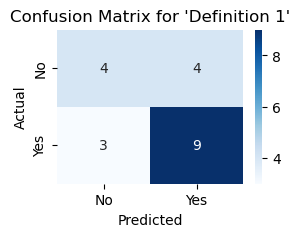

MSE for 'Definition 1': 0.3500



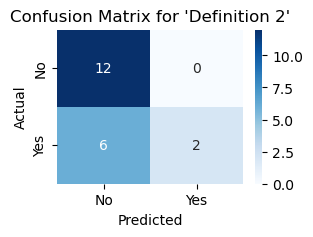

MSE for 'Definition 2': 0.3000



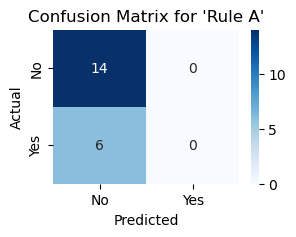

MSE for 'Rule A': 0.3000



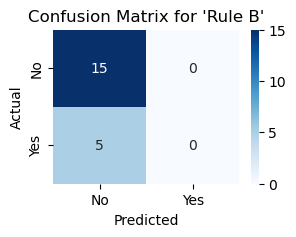

MSE for 'Rule B': 0.2500



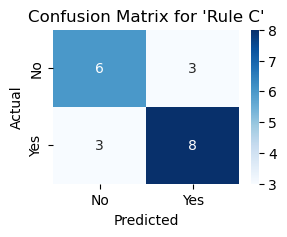

MSE for 'Rule C': 0.3000


Overall MSE across all labels: 0.3000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

# Function to plot confusion matrix and show MSE for a single label
def plot_confusion_matrix_with_error(y_true, y_pred, label):
    # Compute confusion matrix
    cm = confusion_matrix(y_true[label], y_pred[label])
    
    # Plot the heatmap
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for '{label}'")
    plt.show()
    
    # Compute and print MSE for the current label
    mse = mean_squared_error(y_true[label], y_pred[label])
    print(f"MSE for '{label}': {mse:.4f}\n")

# Plot confusion matrix and MSE for each label
for label in label_columns:
    plot_confusion_matrix_with_error(y_val, y_pred_df, label)

# Compute and print overall MSE across all labels
overall_mse = mean_squared_error(y_val[label_columns].values, y_pred_df[label_columns].values)
print(f"\nOverall MSE across all labels: {overall_mse:.4f}")


## XgBoost

In [8]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# Create a list of XGBClassifier models with label-wise scale_pos_weight
estimators = []
for label in y_train.columns:
    # Count positives and negatives
    num_pos = (y_train[label] == 1).sum()
    num_neg = (y_train[label] == 0).sum()
    
    # Avoid division by zero
    weight = num_neg / num_pos if num_pos != 0 else 1.0
    
    clf = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=10,
        learning_rate=0.1,
        scale_pos_weight=weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    estimators.append(clf)

# Wrap in MultiOutputClassifier
model = MultiOutputClassifier(estimator=xgb.XGBClassifier(), n_jobs=-1)
model.estimators_ = estimators  # Assign custom estimators

# Fit and predict
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=y_train.columns)

# Overall evaluation metrics
print("Overall Validation Accuracy (exact match):", accuracy_score(y_val, y_pred_df))
print("Micro-average F1-score:", f1_score(y_val, y_pred_df, average="micro"))
print("Classification Report:\n", classification_report(y_val, y_pred_df, target_names=y_train.columns))

# Per-label accuracy
print("\nPer-label Accuracy:")
for label in y_train.columns:
    acc = accuracy_score(y_val[label], y_pred_df[label])
    print(f"{label}: {acc:.4f}")


Overall Validation Accuracy (exact match): 0.35
Micro-average F1-score: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

Definition 1       0.69      0.75      0.72        12
Definition 2       0.67      0.50      0.57         8
      Rule A       0.00      0.00      0.00         6
      Rule B       1.00      0.80      0.89         5
      Rule C       0.75      0.82      0.78        11

   micro avg       0.72      0.62      0.67        42
   macro avg       0.62      0.57      0.59        42
weighted avg       0.64      0.62      0.63        42
 samples avg       0.58      0.47      0.48        42


Per-label Accuracy:
Definition 1: 0.6500
Definition 2: 0.7000
Rule A: 0.6500
Rule B: 0.9500
Rule C: 0.7500


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


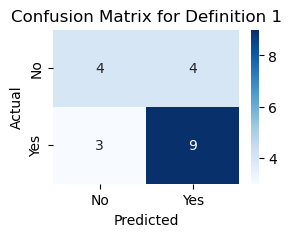

MSE for 'Definition 1': 0.3500



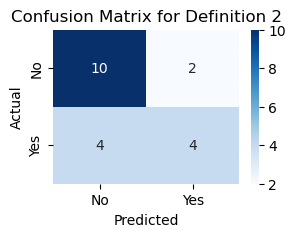

MSE for 'Definition 2': 0.3000



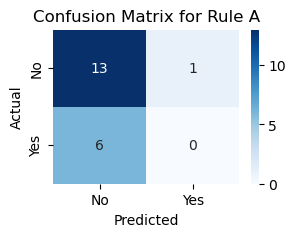

MSE for 'Rule A': 0.3500



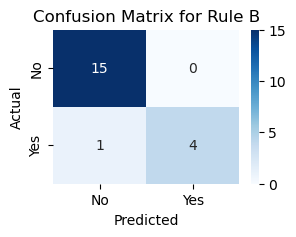

MSE for 'Rule B': 0.0500



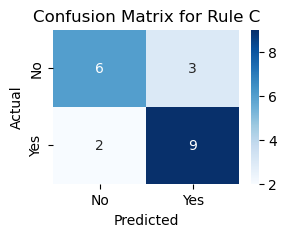

MSE for 'Rule C': 0.2500


Overall MSE across all labels: 0.2600


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

# Function to plot confusion matrix and print MSE
def plot_confusion_matrix_with_mse(y_true, y_pred, label):
    cm = confusion_matrix(y_true[label], y_pred[label])
    
    # Plot confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
    
    # Print MSE for current label
    mse = mean_squared_error(y_true[label], y_pred[label])
    print(f"MSE for '{label}': {mse:.4f}\n")

# Plot for each label
for label in label_columns:
    plot_confusion_matrix_with_mse(y_val, y_pred_df, label)

# Overall MSE across all labels
overall_mse = mean_squared_error(y_val[label_columns].values, y_pred_df[label_columns].values)
print(f"\nOverall MSE across all labels: {overall_mse:.4f}")


## AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# Initialize AdaBoost base model
ada_model = AdaBoostClassifier(n_estimators=15, random_state=42, learning_rate=0.005)
model = MultiOutputClassifier(ada_model)

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=label_columns)

# Overall evaluation
print("Overall Validation Accuracy (exact match):", accuracy_score(y_val, y_pred_df))
print("Micro-average F1-score:", f1_score(y_val, y_pred_df, average="micro"))
print("Classification Report:\n", classification_report(y_val, y_pred_df, target_names=label_columns))

# Per-label accuracy
print("\nPer-label Accuracy:")
for label in label_columns:
    acc = accuracy_score(y_val[label], y_pred_df[label])
    print(f"{label}: {acc:.4f}")


c:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Anaconda\Lib\site-packages\sklearn\ensemble\_weight_boosting.

Overall Validation Accuracy (exact match): 0.35
Micro-average F1-score: 0.6835443037974683
Classification Report:
               precision    recall  f1-score   support

Definition 1       0.69      0.75      0.72        12
Definition 2       0.67      0.50      0.57         8
      Rule A       0.00      0.00      0.00         6
      Rule B       1.00      0.80      0.89         5
      Rule C       0.77      0.91      0.83        11

   micro avg       0.73      0.64      0.68        42
   macro avg       0.63      0.59      0.60        42
weighted avg       0.65      0.64      0.64        42
 samples avg       0.60      0.49      0.51        42


Per-label Accuracy:
Definition 1: 0.6500
Definition 2: 0.7000
Rule A: 0.6500
Rule B: 0.9500
Rule C: 0.8000


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


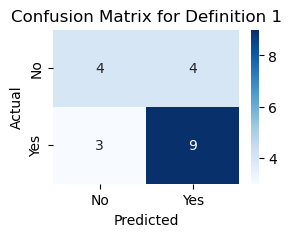

MSE for 'Definition 1': 0.3500



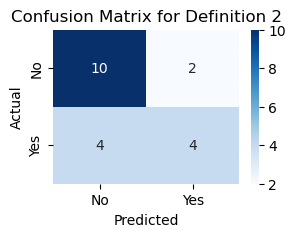

MSE for 'Definition 2': 0.3000



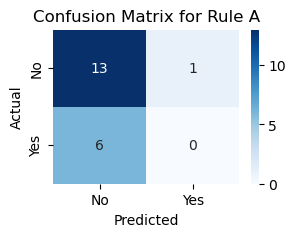

MSE for 'Rule A': 0.3500



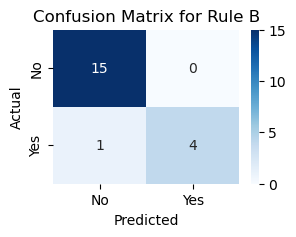

MSE for 'Rule B': 0.0500



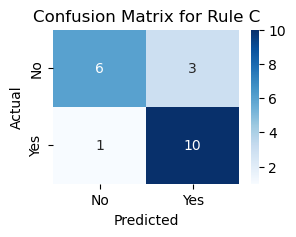

MSE for 'Rule C': 0.2000

Overall MSE across all labels: 0.2500


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

# Function to plot confusion matrix and show MSE
def plot_confusion_matrix_with_mse(y_true, y_pred, label):
    cm = confusion_matrix(y_true[label], y_pred[label])
    
    # Plot confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
    
    # Print MSE for the label
    mse = mean_squared_error(y_true[label], y_pred[label])
    print(f"MSE for '{label}': {mse:.4f}\n")

# Plot confusion matrices and print MSE for each label
for label in label_columns:
    plot_confusion_matrix_with_mse(y_val, y_pred_df, label)

# Calculate and print overall MSE across all label columns
overall_mse = mean_squared_error(y_val[label_columns].values, y_pred_df[label_columns].values)
print(f"Overall MSE across all labels: {overall_mse:.4f}")


## KNN

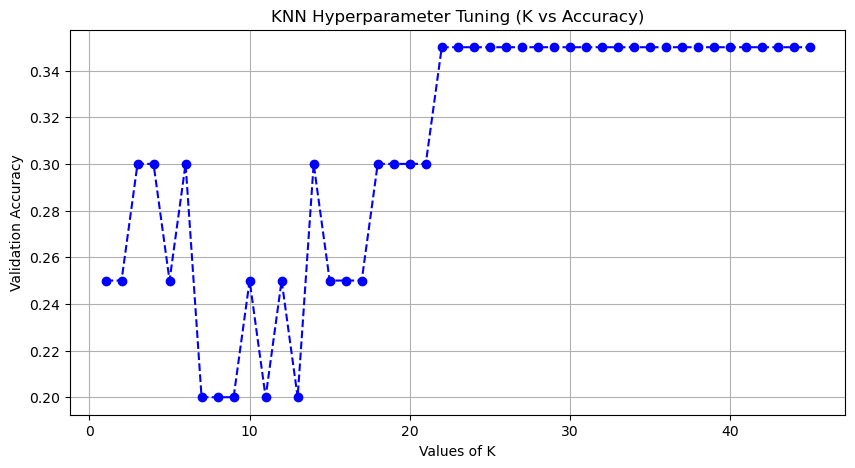

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# Convert sparse matrices to dense arrays
X_train_dense = X_train.toarray() if hasattr(X_train, "toarray") else X_train
X_val_dense = X_val.toarray() if hasattr(X_val, "toarray") else X_val

ks = list(range(1, min(46, len(X_train_dense) + 1)))  # Ensure k ≤ 45
k_values = []

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_dense, y_train)  # Fit using dense array
    k_values.append(knn.score(X_val_dense, y_val))  # Validation accuracy

# Plotting the graph
plt.figure(figsize=(10, 5))
plt.plot(ks, k_values, marker='o', linestyle='dashed', color='b')
plt.xlabel("Values of K")
plt.ylabel("Validation Accuracy")
plt.title("KNN Hyperparameter Tuning (K vs Accuracy)")
plt.grid()
plt.show()


In [13]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# Use KNN instead of XGBoost
knn_model = KNeighborsClassifier(n_neighbors=25)  
model = MultiOutputClassifier(knn_model)

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Convert predictions to DataFrame with same columns
y_pred_df = pd.DataFrame(y_pred, columns=label_columns)

# Evaluation metrics
print("Overall Validation Accuracy (exact match):", accuracy_score(y_val, y_pred_df))
print("Micro-average F1-score:", f1_score(y_val, y_pred_df, average="micro"))
print("Classification Report:\n", classification_report(y_val, y_pred_df, target_names=label_columns))

# Per-label accuracy
print("\nPer-label Accuracy:")
for label in label_columns:
    acc = accuracy_score(y_val[label], y_pred_df[label])
    print(f"{label}: {acc:.4f}")


Overall Validation Accuracy (exact match): 0.35
Micro-average F1-score: 0.5428571428571428
Classification Report:
               precision    recall  f1-score   support

Definition 1       0.69      0.75      0.72        12
Definition 2       1.00      0.25      0.40         8
      Rule A       0.00      0.00      0.00         6
      Rule B       0.00      0.00      0.00         5
      Rule C       0.62      0.73      0.67        11

   micro avg       0.68      0.45      0.54        42
   macro avg       0.46      0.35      0.36        42
weighted avg       0.55      0.45      0.46        42
 samples avg       0.43      0.37      0.38        42


Per-label Accuracy:
Definition 1: 0.6500
Definition 2: 0.7000
Rule A: 0.7000
Rule B: 0.7500
Rule C: 0.6000


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricW

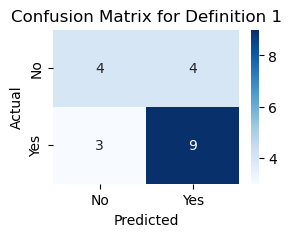

MSE for 'Definition 1': 0.3500



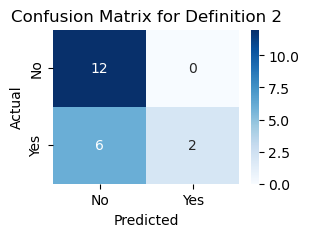

MSE for 'Definition 2': 0.3000



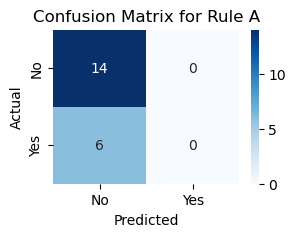

MSE for 'Rule A': 0.3000



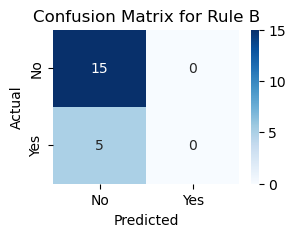

MSE for 'Rule B': 0.2500



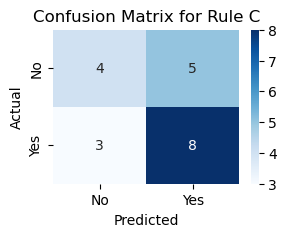

MSE for 'Rule C': 0.4000

Overall MSE across all labels: 0.3200


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

# Function to plot confusion matrix and show MSE
def plot_confusion_matrix(y_true, y_pred, label):
    cm = confusion_matrix(y_true[label], y_pred[label])
    
    # Plot the confusion matrix
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
    
    # Print MSE for the current label
    mse = mean_squared_error(y_true[label], y_pred[label])
    print(f"MSE for '{label}': {mse:.4f}\n")

# Plot confusion matrices and compute MSE for each label
for label in label_columns:
    plot_confusion_matrix(y_val, y_pred_df, label)

# Compute and print overall MSE across all label columns
overall_mse = mean_squared_error(y_val[label_columns].values, y_pred_df[label_columns].values)
print(f"Overall MSE across all labels: {overall_mse:.4f}")


## SVC

In [15]:
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
import pandas as pd

# Define the base SVC model
svc_model = SVC(kernel='linear', class_weight='balanced', random_state=42) 
model = MultiOutputClassifier(svc_model)

# Train the model
model.fit(X_train, y_train)
y_pred = model.predict(X_val)

# Convert predictions to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=label_columns)

# Evaluation metrics
print("Overall Validation Accuracy (exact match):", accuracy_score(y_val, y_pred_df))
print("Micro-average F1-score:", f1_score(y_val, y_pred_df, average="micro"))
print("Classification Report:\n", classification_report(y_val, y_pred_df, target_names=label_columns))

# Per-label accuracy
print("\nPer-label Accuracy:")
for label in label_columns:
    acc = accuracy_score(y_val[label], y_pred_df[label])
    print(f"{label}: {acc:.4f}")


Overall Validation Accuracy (exact match): 0.3
Micro-average F1-score: 0.5609756097560976
Classification Report:
               precision    recall  f1-score   support

Definition 1       0.69      0.75      0.72        12
Definition 2       0.43      0.38      0.40         8
      Rule A       0.33      0.33      0.33         6
      Rule B       1.00      0.20      0.33         5
      Rule C       0.62      0.73      0.67        11

   micro avg       0.57      0.55      0.56        42
   macro avg       0.61      0.48      0.49        42
weighted avg       0.61      0.55      0.54        42
 samples avg       0.36      0.41      0.37        42


Per-label Accuracy:
Definition 1: 0.6500
Definition 2: 0.5500
Rule A: 0.6000
Rule B: 0.8000
Rule C: 0.6000


c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


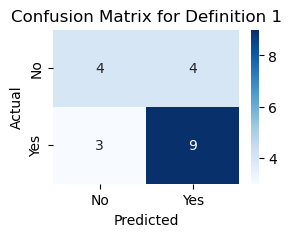

MSE for 'Definition 1': 0.3500



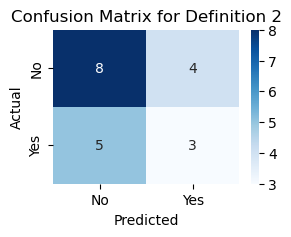

MSE for 'Definition 2': 0.4500



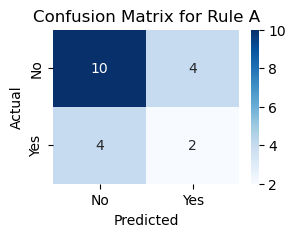

MSE for 'Rule A': 0.4000



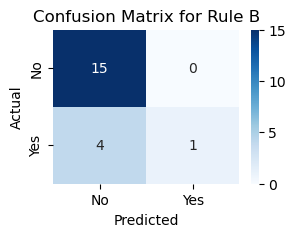

MSE for 'Rule B': 0.2000



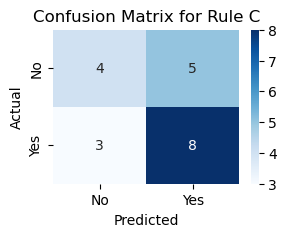

MSE for 'Rule C': 0.4000

Overall MSE across all labels: 0.3600


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, mean_squared_error

# Function to plot confusion matrix and print MSE
def plot_confusion_matrix(y_true, y_pred, label):
    cm = confusion_matrix(y_true[label], y_pred[label])
    
    # Plot confusion matrix
    plt.figure(figsize=(3,2))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()
    
    # Print MSE for current label
    mse = mean_squared_error(y_true[label], y_pred[label])
    print(f"MSE for '{label}': {mse:.4f}\n")

# Plot confusion matrices and print per-label MSE
for label in label_columns:
    plot_confusion_matrix(y_val, y_pred_df, label)

# Compute and print overall MSE across all labels
overall_mse = mean_squared_error(y_val[label_columns], y_pred_df[label_columns])
print(f"Overall MSE across all labels: {overall_mse:.4f}")


## Testing

In [6]:
# ===== Test Data Evaluation for Subtask 2a =====

import pandas as pd
import json

# Load test data
test_df = pd.read_csv('./output/test.csv')

# Preprocess input (just the 'text' column)
X_test_raw = test_df['text']
X_test_vec = vectorizer.transform(X_test_raw)

# Predict using trained model
test_preds = model.predict(X_test_vec)  # Shape: (n_samples, 5)

# Define label map
label_map = {0: "no", 1: "yes"}

# Build structured output as a dict with note_id as keys
output_dict = {}
for i, row in enumerate(test_preds):
    note_id = str(test_df.loc[i, 'note_id'])  # Convert to string key
    output_dict[note_id] = {
        "Definition 1": label_map[int(row[0])],
        "Definition 2": label_map[int(row[1])],
        "Rule A": label_map[int(row[2])],
        "Rule B": label_map[int(row[3])],
        "Rule C": label_map[int(row[4])],
    }

# Save to JSON
with open('./output/subtask_2a.json', 'w') as f:
    json.dump(output_dict, f, indent=4)

print("✅ Predictions saved in dictionary format to ./output/subtask2a_test_predictions.json")


✅ Predictions saved in dictionary format to ./output/subtask2a_test_predictions.json
